## TTC Headway Analysis 
By Bohan

The 'headway' is the length of time between the arrival times of two consecutive trains at a given station. Using cleansed  data from arrival_time_exploration_ver2.ipynb (Bloor-Danforth, April 2019), I intend to run similar head way analysis as Mohamed (https://github.com/moh-osman/ttc_subway_times/blob/master/doc/ttc_headway_analysis.ipynb)  
  
### Major Changes
1. Drop data where a train stops at one station for more than 2 requests
2. Headway calculation: caculates between two trains and uses both timint for first train and next train
3. Change timedelta objects into float array for ploting and stats


### Issues
1. Is the result realistic? (low mean waiting time and vriability at Yong and headway can be very long (e.g. over 3hrs)
2. I did not find trains with both 'train_message' == 'Delayed' and  'timint'==0  
    Will it be a problem in the future?
3. Any bugs or things we did not consider

### Import data from previous code

In [1]:
import datetime; 
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import matplotlib.pyplot as plt; # for plotting

df = pd.read_csv('merged_2019_04.csv'); # import data from Arrival_time_exploration_ver2


# sort data by train direction, station, and request date (ascending)
df.sort_values(by=['traindirection','station_char','request_date'], inplace=True);
df.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
13653,7602955,1343012,29390267135,BAT,BD,0.754087,East,231,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 06:12:43,18767,2019-04-01 06:12:46.431078-04:00,2019-04-01,06:12:46.431078
14751,7567675,1336951,29390382862,BAT,BD,1.009087,East,233,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 06:18:44,18683,2019-04-01 06:18:44.943477-04:00,2019-04-01,06:18:44.943477
16677,7594746,1341581,29390545520,BAT,BD,1.009087,East,237,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 06:26:50,18747,2019-04-01 06:26:50.736969-04:00,2019-04-01,06:26:50.736969
17481,7564812,1336434,29390677127,BAT,BD,0.000000,East,239,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 06:32:47,18676,2019-04-01 06:32:48.359602-04:00,2019-04-01,06:32:48.359602
18934,7395160,1307346,29390764535,BAT,BD,0.754087,East,242,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 06:36:49,18276,2019-04-01 06:36:49.663383-04:00,2019-04-01,06:36:49.663383
19732,7571609,1337616,29390851571,BAT,BD,1.432876,East,244,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 06:40:48,18692,2019-04-01 06:40:48.974792-04:00,2019-04-01,06:40:48.974792
40,7558005,1335253,29391178816,BAT,BD,0.000000,East,201,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 06:56:47,18660,2019-04-01 06:56:49.377142-04:00,2019-04-01,06:56:49.377142
1081,7374991,1303965,29391268244,BAT,BD,0.754087,East,203,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:00:46,18230,2019-04-01 07:00:47.319746-04:00,2019-04-01,07:00:47.319746
2165,7508612,1326846,29391358138,BAT,BD,1.009087,East,206,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:04:48,18545,2019-04-01 07:04:48.597785-04:00,2019-04-01,07:04:48.597785
3295,7506378,1326476,29391486938,BAT,BD,0.000000,East,208,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:10:48,18540,2019-04-01 07:10:49.278513-04:00,2019-04-01,07:10:49.278513


Find the first and last times of a train at each station using the same approach as Mohamed Osman

In [2]:
first_last_vals = (df.trainid.shift(-1,fill_value = -1) == df.trainid) != (
        df.trainid.shift(1,fill_value = -1) == df.trainid);

ttc_2 = df.copy().loc[first_last_vals == True];
ttc_2.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
6400,7488000,1323242,29391743270,BAT,BD,1.432876,East,216,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:22:51,18494,2019-04-01 07:22:51.796585-04:00,2019-04-01,07:22:51.796585
6402,7554436,1334661,29391783974,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:24:46,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117
12390,7425062,1312419,29392341283,BAT,BD,1.595241,East,228,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 07:50:48,18345,2019-04-01 07:50:48.650324-04:00,2019-04-01,07:50:48.650324
12392,7417845,1311235,29392384225,BAT,BD,0.000000,East,228,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 07:52:50,18329,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759
16752,7601532,1342740,29392809357,BAT,BD,1.009087,East,237,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:12:50,18763,2019-04-01 08:12:51.402600-04:00,2019-04-01,08:12:51.402600
16754,7518393,1328466,29392852982,BAT,BD,0.000000,East,237,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:14:49,18567,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966
16861,7601072,1342666,29392894668,BAT,BD,0.754087,East,238,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:16:45,18762,2019-04-01 08:16:46.205619-04:00,2019-04-01,08:16:46.205619
16864,7421917,1311901,29392938499,BAT,BD,0.000000,East,238,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:18:52,18338,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278
19114,7533720,1331102,29393109008,BAT,BD,1.740607,East,243,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 08:26:48,18603,2019-04-01 08:26:49.090864-04:00,2019-04-01,08:26:49.090864
19116,7425968,1312567,29393151054,BAT,BD,0.000000,East,243,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 08:28:49,18347,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954


In [3]:
# Some trains stayed longer
ttc_2[ttc_2.trainid.shift(2,fill_value = -1) == ttc_2.trainid]

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,stationid,lineid,create_date,pollid,request_date,date,time
6755,7392055,1306828,29401359939,BAT,BD,1.586704,East,216,Arriving,Westbound<br/> To Kipling,46,2,2019-04-01 16:26:45,18269,2019-04-01 16:26:46.338862-04:00,2019-04-01,16:26:46.338862
6757,7520001,1328758,29401406573,BAT,BD,0.000000,East,216,AtStation,Westbound<br/> To Kipling,46,2,2019-04-01 16:28:45,18571,2019-04-01 16:28:47.426774-04:00,2019-04-01,16:28:47.426774
134072,676158,119954,29509571200,BAT,BD,1.690013,East,217,Arriving,Westbound<br/> To Kipling,46,2,2019-04-06 07:56:57,1658,2019-04-06 07:56:57.751969-04:00,2019-04-06,07:56:57.751969
134074,605304,106204,29509611227,BAT,BD,0.000000,East,217,AtStation,Westbound<br/> To Kipling,46,2,2019-04-06 07:58:55,1462,2019-04-06 07:58:57.109420-04:00,2019-04-06,07:58:57.109420
146007,880347,159385,29552357836,BAT,BD,1.961882,East,210,Arriving,Westbound<br/> To Kipling,46,2,2019-04-07 22:04:47,2218,2019-04-07 22:04:48.039202-04:00,2019-04-07,22:04:48.039202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540220,6929269,1227156,29988184762,WDB,BD,0.000000,West,229,AtStation,Eastbound<br/> To Kennedy,59,2,2019-04-25 19:42:56,17173,2019-04-25 19:42:59.544569-04:00,2019-04-25,19:42:59.544569
231563,2109002,374824,29624410128,YNG,BD,0.000000,West,207,AtStation,Westbound<br/> To Kipling,50,1,2019-04-11 00:08:30,5202,2019-04-11 00:08:31.860963-04:00,2019-04-11,00:08:31.860963
231566,2109196,374858,29624415931,YNG,BD,0.000000,West,207,AtStation,Westbound<br/> To Kipling,50,2,2019-04-11 00:08:48,5202,2019-04-11 00:08:48.656883-04:00,2019-04-11,00:08:48.656883
493591,7096811,1255583,29935250500,YNG,BD,0.000000,West,235,AtStation,Westbound<br/> To Kipling,50,2,2019-04-23 18:10:00,17564,2019-04-23 18:10:01.081780-04:00,2019-04-23,18:10:01.081780


In [4]:
# Remove these trains
ttc_2.drop(ttc_2[(ttc_2.trainid.shift(-1,fill_value = -1) == ttc_2.trainid) & (
        ttc_2.trainid.shift(1,fill_value = -1) == ttc_2.trainid)].index,inplace=True)

#### Calculate headway using the first/last arrival times using the same approach as Mohamed Osman
 i.e. get rid of first arrival times from dataset and append first request times to last arrival time rows also chop off the first row (headway will be 0)
 
#### I added timint and extra date and time in my data set

In [5]:
ttc_3 = ttc_2.copy();
ttc_3['rd2'] = ttc_2.request_date.shift(1,fill_value = ttc_2.iloc[0]['request_date']);
ttc_3['time2'] = ttc_2.time.shift(1,fill_value = ttc_2.iloc[0]['time']);
ttc_3['tid2'] = ttc_2.trainid.shift(1,fill_value = ttc_2.iloc[0]['trainid']);
ttc_3['timint2'] = ttc_2.timint.shift(1,fill_value = ttc_2.iloc[0]['timint']);
ttc_3['date2'] = ttc_2.date.shift(1,fill_value = ttc_2.iloc[0]['date']);

ttc_4 = ttc_3[1:].copy().loc[(ttc_3['trainid'] == ttc_3['tid2'])];
ttc_4.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,create_date,pollid,request_date,date,time,rd2,time2,tid2,timint2,date2
6402,7554436,1334661,29391783974,BAT,BD,0.0,East,216,AtStation,Westbound<br/> To Kipling,...,2019-04-01 07:24:46,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,2019-04-01 07:22:51.796585-04:00,07:22:51.796585,216,1.432876,2019-04-01
12392,7417845,1311235,29392384225,BAT,BD,0.0,East,228,AtStation,Westbound<br/> To Kipling,...,2019-04-01 07:52:50,18329,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759,2019-04-01 07:50:48.650324-04:00,07:50:48.650324,228,1.595241,2019-04-01
16754,7518393,1328466,29392852982,BAT,BD,0.0,East,237,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:14:49,18567,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966,2019-04-01 08:12:51.402600-04:00,08:12:51.402600,237,1.009087,2019-04-01
16864,7421917,1311901,29392938499,BAT,BD,0.0,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:18:52,18338,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278,2019-04-01 08:16:46.205619-04:00,08:16:46.205619,238,0.754087,2019-04-01
19116,7425968,1312567,29393151054,BAT,BD,0.0,East,243,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:28:49,18347,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954,2019-04-01 08:26:49.090864-04:00,08:26:49.090864,243,1.740607,2019-04-01
19807,7565711,1336582,29393191406,BAT,BD,0.0,East,244,AtStation,Westbound<br/> To Kipling,...,2019-04-01 08:30:56,18678,2019-04-01 08:30:57.294707-04:00,2019-04-01,08:30:57.294707,2019-04-01 08:28:50.102954-04:00,08:28:50.102954,244,1.432876,2019-04-01
15684,7365132,1302232,29394626867,BAT,BD,0.0,East,235,AtStation,Westbound<br/> To Kipling,...,2019-04-01 09:54:38,18206,2019-04-01 09:54:38.828883-04:00,2019-04-01,09:54:38.828883,2019-04-01 09:52:44.711823-04:00,09:52:44.711823,235,1.021368,2019-04-01
16931,7463145,1318948,29394759542,BAT,BD,0.0,East,238,AtStation,Westbound<br/> To Kipling,...,2019-04-01 10:02:35,18435,2019-04-01 10:02:38.697234-04:00,2019-04-01,10:02:38.697234,2019-04-01 10:00:43.092103-04:00,10:00:43.092103,238,1.021368,2019-04-01
183,7577300,1338628,29395304442,BAT,BD,0.0,East,201,AtStation,Westbound<br/> To Kipling,...,2019-04-01 10:30:47,18706,2019-04-01 10:30:51.544849-04:00,2019-04-01,10:30:51.544849,2019-04-01 10:28:50.711713-04:00,10:28:50.711713,201,1.452060,2019-04-01
13049,7565257,1336508,29396361049,BAT,BD,0.0,East,229,AtStation,Westbound<br/> To Kipling,...,2019-04-01 11:30:36,18677,2019-04-01 11:30:38.717516-04:00,2019-04-01,11:30:38.717516,2019-04-01 11:28:41.665897-04:00,11:28:41.665897,229,1.764802,2019-04-01


### Calculate headway:  
Headway is (what i assume to be) the time between train arrivals along with the estimated time left before arrival  
#### Mathematically, headway = (last.request_time + last.timint) - (first.request_time + first.timint)
  
#### Note: you have to reset_index() before arithmetics! Or, it caculates based on index of series


In [6]:
# reset index
ttc_4.reset_index(drop=True,inplace=True);

# previous train
a = pd.to_datetime(ttc_4['request_date'][:-1]) + pd.to_timedelta(
        ttc_4['timint'][:-1],unit='m');
# next train
b = pd.to_datetime(ttc_4['rd2'][1:]) + pd.to_timedelta(
        ttc_4['timint2'][1:],unit='m');
# MUST reset index here                   
headway = b.reset_index(drop=True)-a.reset_index(drop=True);

# make new dataset with relevant information
# omit last row because headway does not exist (i.e. no index)
ttc_5 = ttc_4[:-1].copy();

ttc_5['headway'] = headway;
ttc_5.head(15)

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,pollid,request_date,date,time,rd2,time2,tid2,timint2,date2,headway
0,7554436,1334661,29391783974,BAT,BD,0.0,East,216,AtStation,Westbound<br/> To Kipling,...,18652,2019-04-01 07:24:47.054117-04:00,2019-04-01,07:24:47.054117,2019-04-01 07:22:51.796585-04:00,07:22:51.796585,216,1.432876,2019-04-01,00:27:37.310653
1,7417845,1311235,29392384225,BAT,BD,0.0,East,228,AtStation,Westbound<br/> To Kipling,...,18329,2019-04-01 07:52:51.553759-04:00,2019-04-01,07:52:51.553759,2019-04-01 07:50:48.650324-04:00,07:50:48.650324,228,1.595241,2019-04-01,00:21:00.394056
2,7518393,1328466,29392852982,BAT,BD,0.0,East,237,AtStation,Westbound<br/> To Kipling,...,18567,2019-04-01 08:14:50.008966-04:00,2019-04-01,08:14:50.008966,2019-04-01 08:12:51.402600-04:00,08:12:51.402600,237,1.009087,2019-04-01,00:02:41.441868
3,7421917,1311901,29392938499,BAT,BD,0.0,East,238,AtStation,Westbound<br/> To Kipling,...,18338,2019-04-01 08:18:53.764278-04:00,2019-04-01,08:18:53.764278,2019-04-01 08:16:46.205619-04:00,08:16:46.205619,238,0.754087,2019-04-01,00:09:39.763001
4,7425968,1312567,29393151054,BAT,BD,0.0,East,243,AtStation,Westbound<br/> To Kipling,...,18347,2019-04-01 08:28:50.102954-04:00,2019-04-01,08:28:50.102954,2019-04-01 08:26:49.090864-04:00,08:26:49.090864,243,1.740607,2019-04-01,00:01:25.972569
5,7565711,1336582,29393191406,BAT,BD,0.0,East,244,AtStation,Westbound<br/> To Kipling,...,18678,2019-04-01 08:30:57.294707-04:00,2019-04-01,08:30:57.294707,2019-04-01 08:28:50.102954-04:00,08:28:50.102954,244,1.432876,2019-04-01,01:22:48.699224
6,7365132,1302232,29394626867,BAT,BD,0.0,East,235,AtStation,Westbound<br/> To Kipling,...,18206,2019-04-01 09:54:38.828883-04:00,2019-04-01,09:54:38.828883,2019-04-01 09:52:44.711823-04:00,09:52:44.711823,235,1.021368,2019-04-01,00:07:05.545328
7,7463145,1318948,29394759542,BAT,BD,0.0,East,238,AtStation,Westbound<br/> To Kipling,...,18435,2019-04-01 10:02:38.697234-04:00,2019-04-01,10:02:38.697234,2019-04-01 10:00:43.092103-04:00,10:00:43.092103,238,1.021368,2019-04-01,00:27:39.138067
8,7577300,1338628,29395304442,BAT,BD,0.0,East,201,AtStation,Westbound<br/> To Kipling,...,18706,2019-04-01 10:30:51.544849-04:00,2019-04-01,10:30:51.544849,2019-04-01 10:28:50.711713-04:00,10:28:50.711713,201,1.452060,2019-04-01,00:59:36.009196
9,7565257,1336508,29396361049,BAT,BD,0.0,East,229,AtStation,Westbound<br/> To Kipling,...,18677,2019-04-01 11:30:38.717516-04:00,2019-04-01,11:30:38.717516,2019-04-01 11:28:41.665897-04:00,11:28:41.665897,229,1.764802,2019-04-01,00:59:45.173864


#### Remove headway between last train in the early morning and first train after 6am
#### by removing headway greater than 4 hours and less than 0 days (some have negative days)
#### Then, change headway column into numbers with unit: min

In [7]:
# remove first train of a new day (starts at 6a.m.)
# by removing headway greater than 4 hours and less than 0 days
ttc_5.drop(ttc_5[(ttc_5['headway'] > pd.to_timedelta('4 hours')) | (
        ttc_5['headway'] < pd.to_timedelta('0 days'))].index,inplace=True);

# change headway column into numbers with unit: min
ttc_5['headway'] = np.array(ttc_5['headway'].astype('timedelta64[ms]'))/60000;

### Plot for Eastbound trains in July, 2019


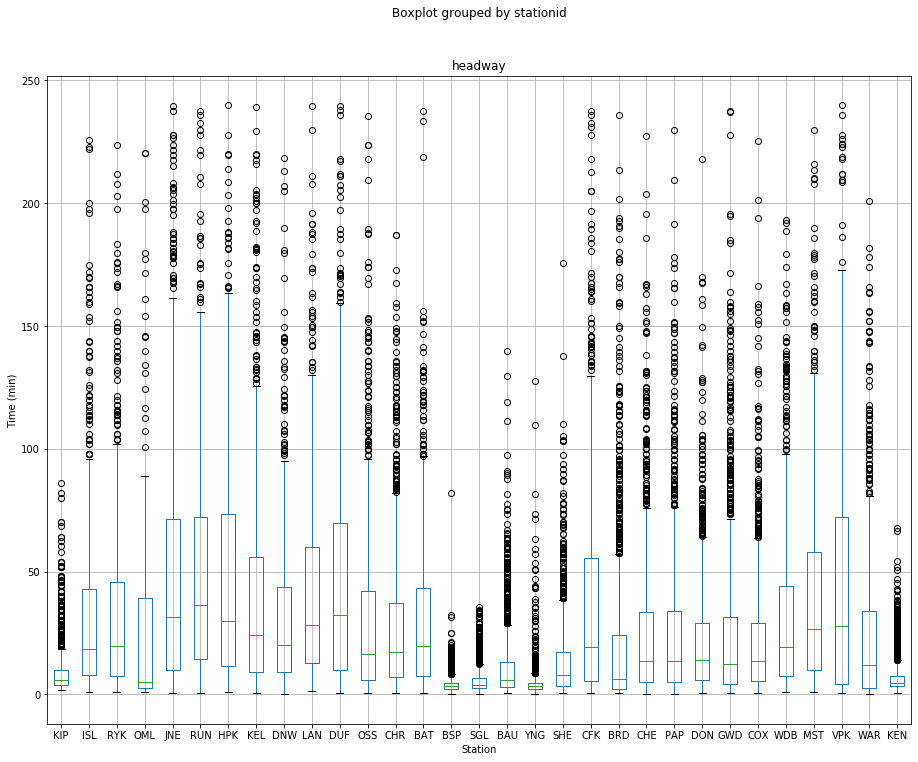

In [8]:
ttc_efa = ttc_5.loc[ttc_5['traindirection'] == 'East', 
        ['stationid','station_char','headway']].copy();
# sort stations from KIP to KEN
ttc_efa.sort_values(by=['stationid'], inplace=True);

plt.rcParams['figure.figsize'] = [15, 12];
f1 = ttc_efa.boxplot(column=['headway'],by='stationid');
f1.set_xticklabels(ttc_efa['station_char'].unique(), fontdict=None, minor=False);
f1.set_xlabel('Station');
f1.set_ylabel('Time (min)');


In [9]:
ttc_efa.drop(['stationid'], axis=1).groupby('station_char').describe()

headway                                                        \
               count       mean        std       min        25%        50%   
station_char                                                                 
BAT            986.0  30.089980  31.262680  0.582417   7.633833  19.745325   
BAU           3068.0  10.117658  12.328321  0.538017   2.798871   5.823467   
BRD           1294.0  20.952279  33.684201  0.608183   1.992354   6.411008   
BSP           8420.0   3.729251   2.281694  0.039417   2.198875   3.390408   
CFK            748.0  38.547288  46.263143  0.610600   5.433388  19.308642   
CHE           1101.0  25.945149  32.212774  0.017000   5.025733  13.418600   
CHR           1078.0  27.976556  31.065670  0.598767   7.208696  17.221583   
COX           1346.0  22.043148  25.530872  0.411083   5.598258  13.567700   
DNW            590.0  33.779564  36.864086  0.255000   9.099771  19.899242   
DON           1433.0  21.825180  23.974523  0.698567   5.849683  13.982167   
DUF            430.0  51.551733  53.624831  0.646517   9.906904  32.485392   
GWD           1136.0  26.440244  35.370401  0.718767   4.155963  12.549767   
HPK            543.0  49.328306  50.222324  0.776183  11.732525  30.022383   
ISL            898.0  31.391143  35.532719  0.783533   7.744192  18.595383   
JNE            487.0  51.160497  56.382202  0.665100   9.885267  31.378067   
KEL            571.0  44.818405  51.095555  0.689467   8.981492  24.040617   
KEN           3697.0   6.389558   5.563066  0.394700   3.220750   4.557733   
KIP           3097.0   8.400139   8.379853  1.647517   3.989500   5.983683   
LAN            510.0  44.317812  44.342853  1.162750  12.563733  28.403325   
MST            662.0  40.800314  42.236716  0.853817   9.764529  26.773058   
OML            118.0  35.249290  57.036837  1.083883   2.516033   5.205925   
OSS            944.0  30.753370  36.737461  0.417183   5.645608  16.272292   
PAP           1168.0  25.896897  32.182792  0.000000   5.227562  13.474983   
RUN            493.0  51.455569  49.722228  0.559117  14.467433  36.199867   
RYK            888.0  32.943884  36.730053  1.034133   7.579638  19.849942   
SGL           6063.0   5.231540   4.058065  0.027233   2.519650   3.936467   
SHE           2480.0  12.532613  14.391859  0.643467   3.315112   7.695450   
VPK            270.0  51.575706  60.880393  0.654750   4.042525  27.941033   
WAR           1100.0  24.725238  31.308797  0.335067   2.663758  11.873583   
WDB            914.0  32.368638  35.397870  0.967600   7.482413  19.481875   
YNG           7743.0   3.826827   3.860065  0.070883   2.069658   3.230450   

                                     
                    75%         max  
station_char                         
BAT           43.420904  237.635900  
BAU           13.134575  139.651150  
BRD           24.033275  235.899183  
BSP            4.687254   81.965217  
CFK           55.514933  237.384883  
CHE           33.613583  227.233883  
CHR           37.254617  187.208750  
COX           28.898592  225.542550  
DNW           43.715475  218.417283  
DON           29.158817  218.105900  
DUF           69.810458  239.500617  
GWD           31.662042  237.537283  
HPK           73.252917  239.905550  
ISL           43.004463  225.772300  
JNE           71.481850  239.777033  
KEL           55.900742  239.275967  
KEN            7.592867   67.556533  
KIP            9.951883   85.998550  
LAN           60.098137  239.700083  
MST           58.166433  229.837417  
OML           39.339421  220.627467  
OSS           41.948479  235.651067  
PAP           33.857550  229.698500  
RUN           72.043567  237.556717  
RYK           45.823892  223.700983  
SGL            6.534192   35.558050  
SHE           17.352271  175.745633  
VPK           72.205646  239.874733  
WAR           34.112529  200.926950  
WDB           43.968358  193.261583  
YNG            4.720958  127.666083

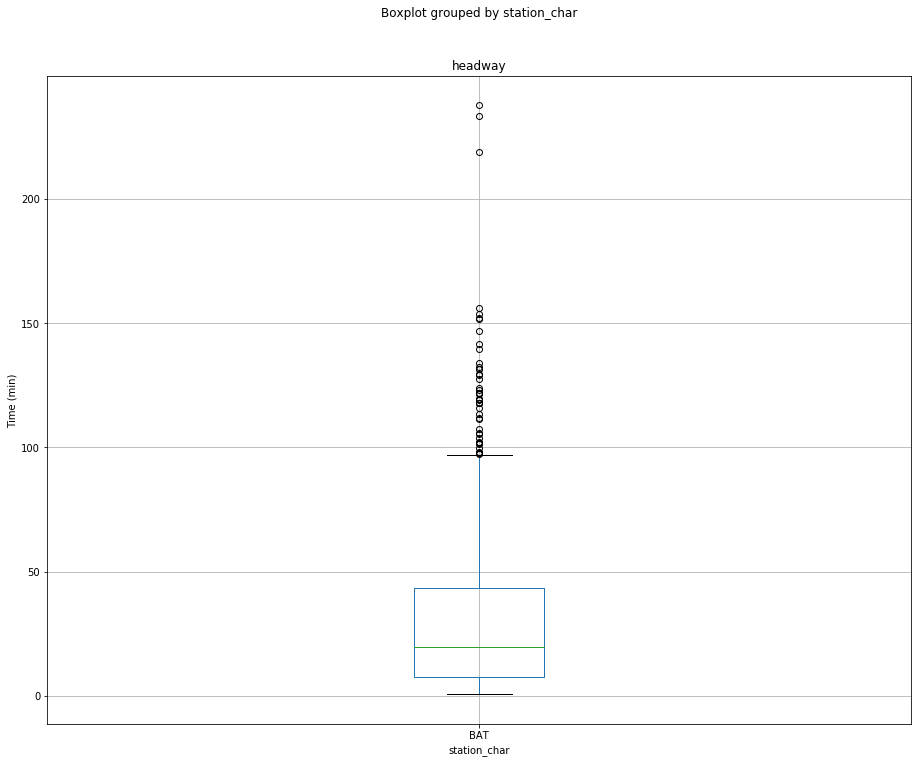

In [10]:
bat1 = ttc_efa.loc[ttc_efa['station_char'] == 'BAT']
b1 = bat1.boxplot(column=['headway'],by='station_char')
b1.set_ylabel('Time (min)');

### What are the ones have long headway time (e.g. over 200 min)

In [11]:
# find long headway trains
ttc_6=ttc_5.reset_index(drop=True)
x = np.where(ttc_6['headway'] > 200);
m = ttc_6.loc[x];
m = pd.concat([m,ttc_6.loc[(x+np.ones(len(x), int)).flatten()]],axis=0);
m.sort_index(inplace=True);
m

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,pollid,request_date,date,time,rd2,time2,tid2,timint2,date2,headway
384,3053348,539462,29656948453,BAT,BD,0.0,East,238,AtStation,Westbound<br/> To Kipling,...,7488,2019-04-12 10:00:55.924952-04:00,2019-04-12,10:00:55.924952,2019-04-12 09:58:56.894768-04:00,09:58:56.894768,238,1.764802,2019-04-12,218.935333
385,3070350,542378,29661204876,BAT,BD,0.0,East,236,AtStation,Westbound<br/> To Kipling,...,7528,2019-04-12 13:44:43.879078-04:00,2019-04-12,13:44:43.879078,2019-04-12 13:38:50.763727-04:00,13:38:50.763727,236,1.021368,2019-04-12,15.563117
638,2282746,405691,29828039523,BAT,BD,0.0,East,220,AtStation,Westbound<br/> To Kipling,...,5632,2019-04-19 15:22:50.752443-04:00,2019-04-19,15:22:50.752443,2019-04-19 15:20:47.814050-04:00,15:20:47.814050,220,1.731144,2019-04-19,233.494817
639,2318333,411988,29833356836,BAT,BD,0.0,East,204,AtStation,Westbound<br/> To Kipling,...,5719,2019-04-19 19:16:47.882454-04:00,2019-04-19,19:16:47.882454,2019-04-19 19:14:47.705718-04:00,19:14:47.705718,204,1.545602,2019-04-19,77.942900
958,6394333,1134207,30103857586,BAT,BD,0.0,East,216,AtStation,Westbound<br/> To Kipling,...,15889,2019-04-30 11:24:45.231025-04:00,2019-04-30,11:24:45.231025,2019-04-30 11:23:15.717296-04:00,11:23:15.717296,216,1.021368,2019-04-30,237.635900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97756,2920889,516448,29648777012,WDB,BD,0.0,West,233,AtStation,Eastbound<br/> To Kennedy,...,7170,2019-04-11 23:18:57.179107-04:00,2019-04-11,23:18:57.179107,2019-04-11 23:16:50.021111-04:00,23:16:50.021111,233,1.729329,2019-04-11,31.149717
97790,5334425,942161,29705316161,WDB,BD,0.0,West,213,AtStation,Eastbound<br/> To Kennedy,...,13120,2019-04-14 19:39:43.224377-04:00,2019-04-14,19:39:43.224377,2019-04-14 19:38:56.265682-04:00,19:38:56.265682,213,1.247321,2019-04-14,200.841267
97791,5360050,947296,29708301994,WDB,BD,0.0,West,217,AtStation,Eastbound<br/> To Kennedy,...,13199,2019-04-14 23:02:08.194608-04:00,2019-04-14,23:02:08.194608,2019-04-14 23:00:06.421596-04:00,23:00:06.421596,217,0.454652,2019-04-14,5.552383
97866,2608987,462601,29799263133,WDB,BD,0.0,West,228,AtStation,Eastbound<br/> To Kennedy,...,6422,2019-04-18 14:02:55.913582-04:00,2019-04-18,14:02:55.913582,2019-04-18 14:01:00.455451-04:00,14:01:00.455451,228,1.810969,2019-04-18,207.767483


In [12]:
ttc_5[ttc_5['train_message'] == 'Delayed' ]

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,pollid,request_date,date,time,rd2,time2,tid2,timint2,date2,headway
37,1195059,216315,29419385616,BAT,BD,1.021368,East,229,Delayed,Westbound<br/> To Kipling,...,3016,2019-04-02 11:34:47.992162-04:00,2019-04-02,11:34:47.992162,2019-04-02 11:32:40.817875-04:00,11:32:40.817875,229,1.021368,2019-04-02,12.331533
59,1285156,231880,29431759320,BAT,BD,1.735614,East,205,Delayed,Westbound<br/> To Kipling,...,3230,2019-04-03 00:52:51.982734-04:00,2019-04-03,00:52:51.982734,2019-04-03 00:46:51.524029-04:00,00:46:51.524029,205,1.735614,2019-04-03,21.362750
143,1767245,315670,29485205602,BAT,BD,1.009087,East,204,Delayed,Westbound<br/> To Kipling,...,4383,2019-04-05 08:50:49.678628-04:00,2019-04-05,08:50:49.678628,2019-04-05 08:48:48.963443-04:00,08:48:48.963443,204,1.009087,2019-04-05,23.221417
145,1738101,310609,29485736071,BAT,BD,0.766368,East,219,Delayed,Westbound<br/> To Kipling,...,4313,2019-04-05 09:18:43.703387-04:00,2019-04-05,09:18:43.703387,2019-04-05 09:16:42.795752-04:00,09:16:42.795752,219,0.766368,2019-04-05,5.071400
601,1381527,248575,29786891515,BAT,BD,1.735614,East,244,Delayed,Westbound<br/> To Kipling,...,3459,2019-04-18 00:24:45.652905-04:00,2019-04-18,00:24:45.652905,2019-04-18 00:20:46.593849-04:00,00:20:46.593849,244,1.735614,2019-04-18,22.268267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99983,1549679,277944,29779437887,WDB,BD,0.467684,West,207,Delayed,Eastbound<br/> To Kennedy,...,3863,2019-04-17 18:56:57.103844-04:00,2019-04-17,18:56:57.103844,2019-04-17 18:52:54.536450-04:00,18:52:54.536450,207,1.776282,2019-04-17,9.339383
99992,2398491,426189,29792659858,WDB,BD,0.470682,West,213,Delayed,Eastbound<br/> To Kennedy,...,5916,2019-04-18 08:10:57.208230-04:00,2019-04-18,08:10:57.208230,2019-04-18 08:06:50.425896-04:00,08:06:50.425896,213,1.531034,2019-04-18,3.021400
99993,2511770,445769,29792788874,WDB,BD,0.315937,West,216,Delayed,Eastbound<br/> To Kennedy,...,6187,2019-04-18 08:16:58.262781-04:00,2019-04-18,08:16:58.262781,2019-04-18 08:12:54.871552-04:00,08:12:54.871552,216,1.531034,2019-04-18,0.975350
101424,3403842,599910,29470138204,YNG,BD,0.669783,West,201,Delayed,Westbound<br/> To Kipling,...,8322,2019-04-04 16:54:33.293397-04:00,2019-04-04,16:54:33.293397,2019-04-04 16:52:33.840678-04:00,16:52:33.840678,201,0.669783,2019-04-04,3.119583


In [13]:
# find trains with both 'train_message' == 'Delayed' and 'timint'==0
ttc_5[(ttc_5['train_message'] == 'Delayed') &((ttc_5['timint'] == 0) | (ttc_5['timint'] == 0))]

,Unnamed: 0,requestid,id,station_char,subwayline,timint,traindirection,trainid,train_message,train_dest,...,pollid,request_date,date,time,rd2,time2,tid2,timint2,date2,headway
